In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.2.2


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "drive/My Drive/data /dataset_updated"

# Number of classes in the dataset
num_classes = 5

model_name = 'resnet'

# Batch size for training (change depending on how much memory you have)
batch_size = 7

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=30, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return(val_acc_history)


In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [0]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [0]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fcef24a1a58>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fcef24a1710>}

### Using Pre-trained Network as Feature Extractor

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] as feature extractor and train the final layer for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

### Training Pre-trained Network from Scratch

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] and train them from scratch for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

In [0]:
def train_call(model_name):
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    return(train_model(model, dataloaders_dict, criterion, optimizer))


In [0]:
## basically, we loop through each model in the model_list

model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']

acc_history_scratch = {}

In [0]:
model_name = 'alexnet'
acc_history_scratch[model_name] = train_call(model_name)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


train Loss: 1.3738 Acc: 0.4222
val Loss: 1.4045 Acc: 0.4871

Epoch 1/29
----------
train Loss: 1.1802 Acc: 0.5330
val Loss: 0.9782 Acc: 0.6273

Epoch 2/29
----------
train Loss: 1.1158 Acc: 0.5646
val Loss: 1.0082 Acc: 0.6402

Epoch 3/29
----------
train Loss: 1.0906 Acc: 0.5701
val Loss: 0.8916 Acc: 0.6671

Epoch 4/29
----------
train Loss: 1.0606 Acc: 0.5929
val Loss: 0.8929 Acc: 0.6554

Epoch 5/29
----------
train Loss: 1.0247 Acc: 0.6034
val Loss: 0.8690 Acc: 0.6624

Epoch 6/29
----------
train Loss: 1.0523 Acc: 0.6033
val Loss: 0.8445 Acc: 0.6671

Epoch 7/29
----------
train Loss: 1.0007 Acc: 0.6199
val Loss: 0.8820 Acc: 0.6928

Epoch 8/29
----------
train Loss: 0.9853 Acc: 0.6315
val Loss: 0.9888 Acc: 0.6367

Epoch 9/29
----------
train Loss: 0.9644 Acc: 0.6380
val Loss: 0.8256 Acc: 0.6939

Epoch 10/29
----------
train Loss: 0.9939 Acc: 0.6326
val Loss: 0.8356 Acc: 0.7196

Epoch 11/29
----------
train Loss: 0.9700 Acc: 0.6405
val Loss: 0.8044 Acc: 0.6998

Epoch 12/29
----------
t

In [0]:
model_name = 'squeezenet'
acc_history_scratch[model_name] = train_call(model_name)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


train Loss: 1.2750 Acc: 0.4881
val Loss: 1.0438 Acc: 0.6121

Epoch 1/29
----------
train Loss: 1.1547 Acc: 0.5600
val Loss: 1.0374 Acc: 0.6086

Epoch 2/29
----------
train Loss: 1.0920 Acc: 0.5883
val Loss: 0.9981 Acc: 0.6390

Epoch 3/29
----------
train Loss: 1.0208 Acc: 0.6298
val Loss: 0.9341 Acc: 0.6741

Epoch 4/29
----------
train Loss: 0.9811 Acc: 0.6521
val Loss: 0.8834 Acc: 0.6904

Epoch 5/29
----------
train Loss: 0.9328 Acc: 0.6662
val Loss: 0.8863 Acc: 0.6729

Epoch 6/29
----------
train Loss: 0.8980 Acc: 0.6810
val Loss: 0.8120 Acc: 0.7173

Epoch 7/29
----------
train Loss: 0.8803 Acc: 0.6899
val Loss: 0.7645 Acc: 0.7348

Epoch 8/29
----------
train Loss: 0.8557 Acc: 0.6965
val Loss: 0.7752 Acc: 0.7290

Epoch 9/29
----------
train Loss: 0.8424 Acc: 0.6980
val Loss: 0.8349 Acc: 0.6928

Epoch 10/29
----------
train Loss: 0.8425 Acc: 0.7013
val Loss: 0.7770 Acc: 0.7348

Epoch 11/29
----------
train Loss: 0.8395 Acc: 0.6999
val Loss: 0.7326 Acc: 0.7465

Epoch 12/29
----------
t

In [0]:
model_name = 'densenet'
acc_history_scratch[model_name] = train_call(model_name)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


train Loss: 1.1357 Acc: 0.5587
val Loss: 1.2022 Acc: 0.5829

Epoch 1/29
----------
train Loss: 0.9726 Acc: 0.6436
val Loss: 1.2200 Acc: 0.6285

Epoch 2/29
----------
train Loss: 0.9061 Acc: 0.6687
val Loss: 0.7325 Acc: 0.7418

Epoch 3/29
----------
train Loss: 0.8557 Acc: 0.6884
val Loss: 0.7799 Acc: 0.7313

Epoch 4/29
----------
train Loss: 0.8111 Acc: 0.7070
val Loss: 0.6730 Acc: 0.7792

Epoch 5/29
----------
train Loss: 0.7685 Acc: 0.7204
val Loss: 0.7585 Acc: 0.7512

Epoch 6/29
----------
train Loss: 0.7454 Acc: 0.7236
val Loss: 0.5783 Acc: 0.8178

Epoch 7/29
----------
train Loss: 0.7104 Acc: 0.7465
val Loss: 0.7180 Acc: 0.7722

Epoch 8/29
----------
train Loss: 0.6719 Acc: 0.7561
val Loss: 0.7304 Acc: 0.7465

Epoch 9/29
----------
train Loss: 0.6498 Acc: 0.7669
val Loss: 0.6017 Acc: 0.8283

Epoch 10/29
----------
train Loss: 0.6244 Acc: 0.7755
val Loss: 1.0956 Acc: 0.7862

Epoch 11/29
----------
train Loss: 0.6089 Acc: 0.7831
val Loss: 0.5040 Acc: 0.8306

Epoch 12/29
----------
t

In [0]:
model_name = 'vgg'
acc_history_scratch[model_name] = train_call(model_name)

Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


train Loss: 1.2640 Acc: 0.5593
val Loss: 0.7090 Acc: 0.7675

Epoch 1/29
----------
train Loss: 0.9603 Acc: 0.6592
val Loss: 0.8336 Acc: 0.7535

Epoch 2/29
----------
train Loss: 0.8754 Acc: 0.6969
val Loss: 0.6666 Acc: 0.7710

Epoch 3/29
----------
train Loss: 0.8208 Acc: 0.7125
val Loss: 0.7444 Acc: 0.7745

Epoch 4/29
----------
train Loss: 0.7570 Acc: 0.7328
val Loss: 0.5722 Acc: 0.7932

Epoch 5/29
----------
train Loss: 0.7344 Acc: 0.7415
val Loss: 0.7930 Acc: 0.7558

Epoch 6/29
----------
train Loss: 0.6991 Acc: 0.7531
val Loss: 0.6180 Acc: 0.7769

Epoch 7/29
----------
train Loss: 0.6803 Acc: 0.7569
val Loss: 0.5439 Acc: 0.8143

Epoch 8/29
----------
train Loss: 0.6590 Acc: 0.7657
val Loss: 0.5606 Acc: 0.8049

Epoch 9/29
----------
train Loss: 0.6484 Acc: 0.7713
val Loss: 0.5252 Acc: 0.8271

Epoch 10/29
----------
train Loss: 0.6241 Acc: 0.7779
val Loss: 0.6957 Acc: 0.7558

Epoch 11/29
----------
train Loss: 0.6183 Acc: 0.7794
val Loss: 0.4900 Acc: 0.8294

Epoch 12/29
----------
t

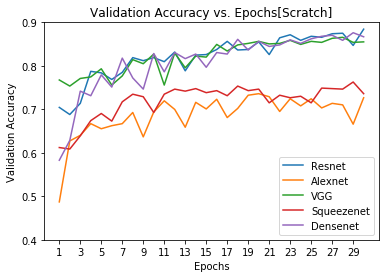

In [0]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
resnet = []
alexnet = []
vgg = []
squeezenet = []
densenet = []

resnet = [h.cpu().numpy() for h in acc_history_scratch['resnet']]
alexnet = [h.cpu().numpy() for h in acc_history_scratch['alexnet']]
vgg = [h.cpu().numpy() for h in acc_history_scratch['vgg']]
squeezenet = [h.cpu().numpy() for h in acc_history_scratch['squeezenet']]
densenet = [h.cpu().numpy() for h in acc_history_scratch['densenet']]

plt.title("Validation Accuracy vs. Epochs[Scratch]")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),resnet,label="Resnet")
plt.plot(range(1,num_epochs+1),alexnet,label="Alexnet")
plt.plot(range(1,num_epochs+1),vgg,label="VGG")
plt.plot(range(1,num_epochs+1),squeezenet,label="Squeezenet")
plt.plot(range(1,num_epochs+1),densenet,label="Densenet")
# plt.plot(range(1,num_epochs+1),inception,label="Inception")
plt.ylim((0.4,0.9))
plt.xticks(np.arange(1, num_epochs + 1, 2.0))
plt.legend()
plt.savefig("scratch_training_zoomed.jpg", bbox_inches='tight')
plt.show()

In [0]:
acc_history_scratch

{'alexnet': [tensor(0.4871, device='cuda:0', dtype=torch.float64),
  tensor(0.6273, device='cuda:0', dtype=torch.float64),
  tensor(0.6402, device='cuda:0', dtype=torch.float64),
  tensor(0.6671, device='cuda:0', dtype=torch.float64),
  tensor(0.6554, device='cuda:0', dtype=torch.float64),
  tensor(0.6624, device='cuda:0', dtype=torch.float64),
  tensor(0.6671, device='cuda:0', dtype=torch.float64),
  tensor(0.6928, device='cuda:0', dtype=torch.float64),
  tensor(0.6367, device='cuda:0', dtype=torch.float64),
  tensor(0.6939, device='cuda:0', dtype=torch.float64),
  tensor(0.7196, device='cuda:0', dtype=torch.float64),
  tensor(0.6998, device='cuda:0', dtype=torch.float64),
  tensor(0.6589, device='cuda:0', dtype=torch.float64),
  tensor(0.7161, device='cuda:0', dtype=torch.float64),
  tensor(0.7009, device='cuda:0', dtype=torch.float64),
  tensor(0.7231, device='cuda:0', dtype=torch.float64),
  tensor(0.6811, device='cuda:0', dtype=torch.float64),
  tensor(0.7021, device='cuda:0', dty

# New Section